In [1]:
import os
import numpy as np
import pandas as pd
import time
import warnings
from matplotlib import pyplot as plt

from sklearn.neural_network import MLPClassifier
import sklearn.metrics
from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Data Preprocessing

Contents of train_x.csv: arr of shape (2102, 784)
Contents of valid_x.csv: arr of shape (600, 784)


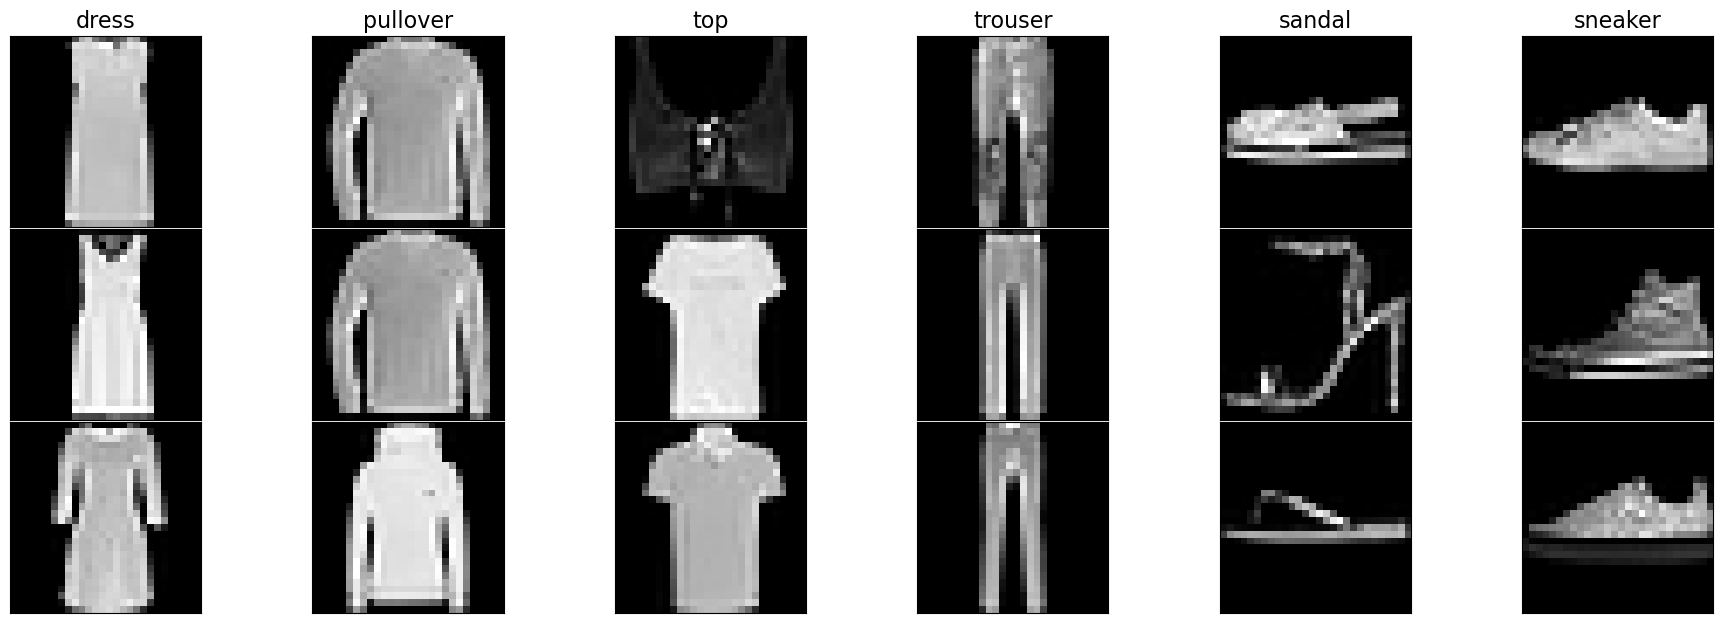

In [2]:
%run load_and_plot_data.py

In [3]:
train_y_df, valid_y_df

(     class_name  class_uid
 0      pullover          2
 1           top          0
 2         dress          3
 3        sandal          5
 4      pullover          2
 ...         ...        ...
 2097     sandal          5
 2098     sandal          5
 2099     sandal          5
 2100     sandal          5
 2101     sandal          5
 
 [2102 rows x 2 columns],
     class_name  class_uid
 0        dress          3
 1        dress          3
 2        dress          3
 3        dress          3
 4        dress          3
 ..         ...        ...
 595    sneaker          7
 596    sneaker          7
 597        top          0
 598        top          0
 599    trouser          1
 
 [600 rows x 2 columns])

In [4]:
temp = np.array(train_y_df)
count_array = temp[:,1]
count_train = np.unique(count_array, return_counts = True)

temp = np.array(valid_y_df)
count_array = temp[:,1]
count_valid = np.unique(count_array, return_counts = True)

In [5]:
count_train, count_valid

((array([0, 1, 2, 3, 5, 7], dtype=object),
  array([  1,   1, 100, 400, 800, 800], dtype=int64)),
 (array([0, 1, 2, 3, 5, 7], dtype=object),
  array([100, 100, 100, 100, 100, 100], dtype=int64)))

In [6]:
train_y = np.array(train_y_df['class_uid'])
train_y.shape

(2102,)

In [7]:
train_x.shape, train_x[0].dtype

((2102, 784), dtype('int64'))

### Data Duplication

In [8]:
# selecting the tops and trousers
top_x = train_x[train_y == 0]
trouser_x = train_x[train_y == 1]
top_y = train_y[train_y == 0]
trouser_y = train_y[train_y == 1]

print(top_x.shape, trouser_x.shape)
print(top_y.shape, trouser_y.shape)

(1, 784) (1, 784)
(1,) (1,)


In [9]:
# selecting the dresses
dress_x = train_x[train_y == 3]
dress_y = train_y[train_y == 3]

In [10]:
# selecting pullovers
pullover_x = train_x[train_y == 2]
pullover_y = train_y[train_y == 2]

#### duplicating tops/trousers

In [159]:
# duplicated top and trouser arrays
top_x_array = np.tile(top_x, (1599, 1))
trouser_x_array = np.tile(trouser_x, (1199, 1))

top_y_array = np.tile(top_y, (1599))
trouser_y_array = np.tile(trouser_y, (1199))

print(top_x_array.shape, trouser_x_array.shape)
print(top_y_array.shape, trouser_y_array.shape)

(1599, 784) (1199, 784)
(1599,) (1199,)


#### Randomly Duplicating

In [158]:
#randomly duplicating dresses
dress_dupe_in = np.random.choice(len(dress_x), size = 200, replace = True)
#print(dress_duplicates_in)
dress_dupe_x = dress_x[dress_dupe_in]
dress_dupe_y = dress_y[dress_dupe_in]
#count = np.unique(dress_duplicates_x, return_counts = True)
#count

In [160]:
dress_x_array = dress_dupe_x
dress_y_array = dress_dupe_y

In [162]:
#randomly duplicating pullovers 
pull_dupe_in = np.random.choice(len(pullover_x), size = 700, replace = True)
#print(dress_duplicates_in)
pull_dupe_x = pullover_x[pull_dupe_in]
pull_dupe_y = pullover_y[pull_dupe_in]
#count = np.unique(dress_duplicates_x, return_counts = True)
#count

In [163]:
pullover_x_array = pull_dupe_x
pullover_y_array = pull_dupe_y

In [164]:
## Adding tops, trousers, and dresses to train_x
temp = np.vstack((train_x, top_x_array))
print(temp.shape)

temp2 = np.vstack((temp, dress_x_array))
print(temp2.shape)

temp3 = np.vstack((temp2, pullover_x_array))
print(temp3.shape)

duplicated_train_x = np.vstack((temp3, trouser_x_array))
print(duplicated_train_x.shape)


t = np.hstack((train_y, top_y_array))
t2 = np.hstack((t, dress_y_array))
t3 = np.hstack((t2, pullover_y_array))
duplicated_train_y = np.hstack((t3, trouser_y_array))
print(top_y_array.shape, dress_y_array.shape, trouser_y_array.shape, pullover_y_array.shape)

print(duplicated_train_x.shape, duplicated_train_y.shape)

(3701, 784)
(3901, 784)
(4601, 784)
(5800, 784)
(1599,) (200,) (1199,) (700,)
(5800, 784) (5800,)


In [165]:
### Normalizing data

scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(duplicated_train_x)
normed_train_x = scaler.transform(duplicated_train_x)
normed_train_x.shape

(5800, 784)

In [166]:
mlp = MLPClassifier(
            activation='relu',
            solver='lbfgs',
            batch_size = 10000,
            learning_rate='adaptive', 
            momentum=0.0,
            tol=1e-5,
            )

In [167]:
mlp_hyperparameter_grid = dict(
    hidden_layer_sizes = [(16,), (32,), (64,)],
    max_iter= [5, 10, 25, 50, 100, 150, 500],
    random_state = [212], 
    learning_rate_init= [0.001], 
    n_iter_no_change=[5, 10, 25, 50, 100],
    alpha=[10, 1e0, 1e-1, 1e-2, 1e-3]
    )

In [168]:
valid_y = np.array(valid_y_df['class_uid'])
valid_y.shape, duplicated_train_y.shape

((600,), (5800,))

### fit on train

In [169]:
### splitter
valid_indicators_L = np.hstack([
    -1 * np.ones(int(np.floor(0.8 * duplicated_train_y.size))), # -1 means never include this example in any test split
    0  * np.ones(duplicated_train_y.size - int(np.floor(0.8 * duplicated_train_y.size))), #  0 means include in the first test split (we count starting at 0 in python)
    ])
my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators_L)

In [170]:
mlp_searcher = sklearn.model_selection.GridSearchCV(estimator = mlp,
                                                    param_grid = mlp_hyperparameter_grid,
                                                    scoring = 'balanced_accuracy',
                                                    cv = my_splitter,
                                                    return_train_score = True,
                                                    refit=False
                                                   )

In [ ]:
start_time_sec = time.time()
mlp_searcher.fit(normed_train_x, duplicated_train_y)
elapsed_time_sec = time.time() - start_time_sec

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_opt

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (sta

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_opt

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (sta

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_opt

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (sta

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_opt

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (sta

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_opt

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (sta

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (sta

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (sta

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_opt

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (sta

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (sta

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_opt

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (sta

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_opt

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_opt

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (sta

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (sta

In [136]:
print(elapsed_time_sec)

mlp_searcher_result = pd.DataFrame(mlp_searcher.cv_results_).copy()
# [mlp_searcher_result.mean_test_score, mlp_searcher_result.params]

1238.412147283554


### Plot hyperparameter search results
TO DO

### Best hyperparameters to get balanced accuracy on validation/test

In [118]:
mlp_searcher.best_params_

{'alpha': 1.0,
 'hidden_layer_sizes': (16,),
 'learning_rate_init': 0.001,
 'max_iter': 100,
 'n_iter_no_change': 5,
 'random_state': 212}

In [154]:
## When searcher is used

best_mlp = mlp 
best_param = mlp_searcher.best_params_
best_mlp.set_params(**best_param)
best_mlp.fit(normed_train_x, duplicated_train_y)

C:\Your\Root\Prefix\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1.0, batch_size=10000, hidden_layer_sizes=(16,),
              learning_rate='adaptive', max_iter=100, momentum=0.0,
              n_iter_no_change=5, random_state=212, solver='lbfgs', tol=1e-05)

In [155]:
### Normalizing data

scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(valid_x)
normed_valid_x = scaler.transform(valid_x)
normed_valid_x.shape

(600, 784)

In [156]:
# normed_valid_x = sklearn.preprocessing.normalize(valid_x, norm = 'max', axis = 1)

pred_y = best_mlp.predict(normed_valid_x)
best_mlp_BAcc = balanced_accuracy_score(valid_y, pred_y)
best_mlp_BAcc

0.715

In [ ]:
pred_y.shape

### Trying to figure out y_pred vs y_true error


In [ ]:
#print(valid_y)
#print(pred_y)


count_pred = pred_y
count_pr_2 = np.unique(count_pred, return_counts = True)

count_val = valid_y
count_valid = np.unique(count_val, return_counts = True)

print(count_valid)
print(count_pr_2)

### Saving as they do in save rand prediction

In [ ]:
# Load the dataset of interest
    datadir = os.path.abspath('data_fashion')
    x_NF = np.loadtxt(
        os.path.join(datadir, 'x_valid.csv'),
        delimiter=',',
        skiprows=1)
    N = x_NF.shape[0]

### Confusion Matrix

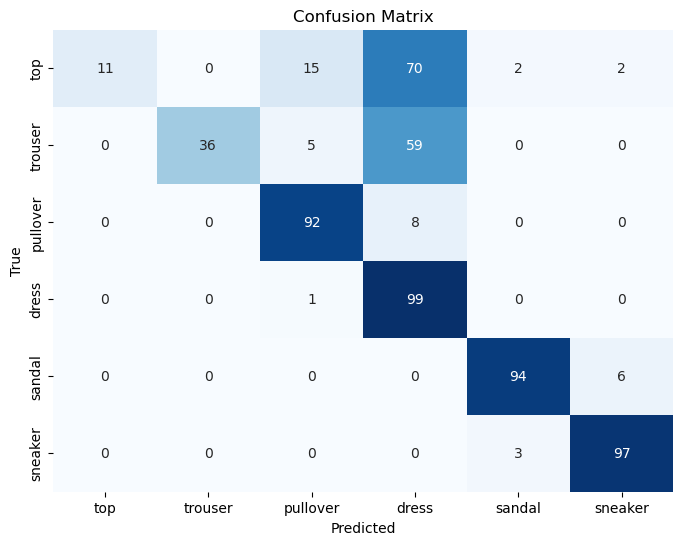

In [157]:
conf_matrix = confusion_matrix(valid_y, pred_y)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['top', 'trouser', 'pullover', 'dress', 'sandal', 'sneaker'],
            yticklabels=['top', 'trouser', 'pullover', 'dress', 'sandal', 'sneaker'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()